In [19]:
import random
!pip install matplotlib
!pip install scipy


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 16.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [20]:
import polars as pl
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Reference Case: Normal Distribution with no Corruption

In [95]:
N = 10000
MU = 0
SIGMA = 1

In [105]:
df = pl.DataFrame({
    "i": np.arange(0, N, 1),
    "x": np.random.normal(MU, SIGMA, 10000)
})

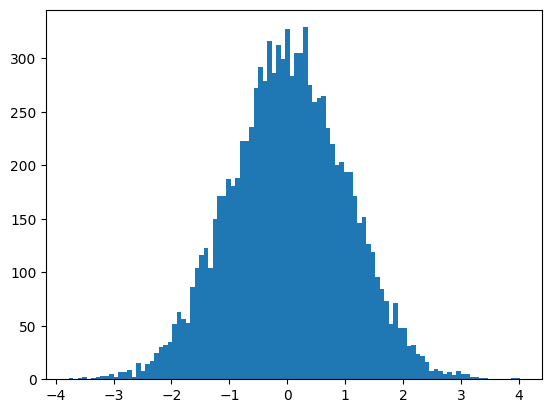

In [106]:
plt.hist(df["x"].to_numpy(), bins=100);

In [107]:
mean, sd = df["x"].mean(), df["x"].std()

In [108]:
# Dataframe where columns are mean, std and rows are true, estimated and delta.

print(f"Estimated:\n\tµ: {mean:.10f}, σ: {sd:.10f}")
print(f"True:\n\tµ: {MU:.10f}, σ: {SIGMA:.10f}")
print(f"Dist:\n\tµ: {abs(mean - MU):.10f}, σ: {abs(sd - SIGMA):.10f}")

Estimated:
	µ: 0.0209130539, σ: 1.0061028657
True:
	µ: 0.0000000000, σ: 1.0000000000
Dist:
	µ: 0.0209130539, σ: 0.0061028657


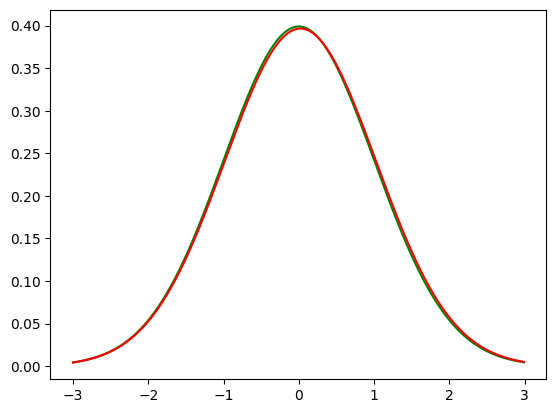

In [109]:
xs = np.arange(-3, 3, 0.01)
plt.plot(xs, scipy.stats.norm.pdf(xs, 0, 1), color="green")
plt.plot(xs, scipy.stats.norm.pdf(xs, mean, sd), color="red")

In [110]:
df["x"].max()

4.008590444130833

# With contamination

In [209]:
CONTAMINATION = 0.10

bad_idxs = sorted(np.random.choice(df.height, int(df.height * CONTAMINATION), replace=False))

In [218]:
bad_df = df.with_columns(
    is_bad=pl.col("i").is_in(bad_idxs),
    x=pl
    .when(pl.col("i").is_in(bad_idxs))
    .then(pl.col("x") * 100 + random.randint(-200, 200))
    .otherwise(pl.col("x"))
)

NameError: name 'random' is not defined

In [219]:
bad_df["x"].describe()

statistic,value
str,f64
"""count""",10000.0
"""null_count""",0.0
"""mean""",0.885327
"""std""",30.684455
"""min""",-349.485216
"""max""",296.61784
"""median""",0.020006
"""25%""",-0.739435
"""75%""",0.800112


In [220]:
df["x"].describe()

statistic,value
str,f64
"""count""",10000.0
"""null_count""",0.0
"""mean""",0.020913
"""std""",1.006103
"""min""",-3.77435
"""max""",4.00859
"""median""",0.018115
"""25%""",-0.653697
"""75%""",0.703674


In [221]:
bad_mean, bad_sd = bad_df["x"].mean(), bad_df["x"].std()
bad_med, bad_mad = bad_df["x"].median(), 1.4826 * (bad_df["x"] - bad_df["x"].median()).abs().median()

In [222]:
# Dataframe where columns are mean, std and rows are true, estimated and delta.

print(f"True:\n\tµ: {MU:.10f}, σ: {SIGMA:.10f}")
print(f"Non-Robust:\n\tµ: {bad_mean:.10f}, σ: {bad_sd:.10f}")
print(f"Robust:\n\tµ: {bad_med:.10f}, σ: {bad_mad:.10f}")
print(f"Dist:\n\t∆µ: {abs(bad_mean - MU):.10f}, ∆σ: {abs(bad_sd - SIGMA):.10f}")
print(f"Robust Dist:\n\t∆µ: {abs(bad_med - MU):.10f}, ∆σ: {abs(bad_mad - SIGMA):.10f}")


True:
	µ: 0.0000000000, σ: 1.0000000000
Non-Robust:
	µ: 0.8853265403, σ: 30.6844547206
Robust:
	µ: 0.0200055431, σ: 1.1378069971
Dist:
	∆µ: 0.8853265403, ∆σ: 29.6844547206
Robust Dist:
	∆µ: 0.0200055431, ∆σ: 0.1378069971


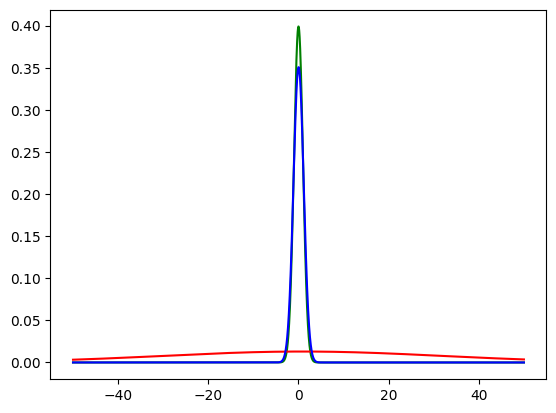

In [223]:
xs = np.arange(-50, 50, 0.01)
plt.plot(xs, scipy.stats.norm.pdf(xs, 0, 1), color="green")
plt.plot(xs, scipy.stats.norm.pdf(xs, bad_mean, bad_sd), color="red")
plt.plot(xs, scipy.stats.norm.pdf(xs, bad_med, bad_mad), color="blue")

In [224]:
bad_df2 = bad_df.with_columns(
    is_outlier=(pl.col("x") - bad_med).abs() > 3 * bad_mad
)
bad_df2

i,x,is_bad,is_outlier
i64,f64,bool,bool
0,0.154001,false,false
1,1.10487,false,false
2,-66.389861,true,true
3,-1.770754,false,false
4,-1.530646,false,false
5,-0.813293,false,false
6,1.432335,false,false
7,19.05326,true,true
8,0.582321,false,false


In [225]:
bad_df2.filter(pl.col("is_bad")).height

1000

In [226]:
bad_df2.filter(pl.col("is_outlier")).height

977

In [227]:
bad_df2.filter(pl.col("is_outlier").is_not() & pl.col("is_bad"))

i,x,is_bad,is_outlier
i64,f64,bool,bool
130,-3.015735,true,false
541,-1.694681,true,false
1046,-0.623281,true,false
1092,-0.768808,true,false
1398,2.401312,true,false
1406,2.793765,true,false
1506,-0.340676,true,false
1661,1.70864,true,false
1859,-0.358454,true,false


In [228]:
scipy.stats.shapiro(bad_df2["x"])

/Users/dylan/PycharmProjects/renkon/.hatch/renkon/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.38134193420410156, pvalue=0.0)

In [229]:
scipy.stats.shapiro(bad_df2.filter(pl.col("is_outlier").is_not())["x"])

ShapiroResult(statistic=0.999767005443573, pvalue=0.436844140291214)

In [230]:
ref_mean = bad_df2.filter(pl.col("is_outlier").is_not())["x"].mean()
ref_std = bad_df2.filter(pl.col("is_outlier").is_not())["x"].std()
ref_mean, ref_std

(0.014442016293436673, 1.0099280603366745)

In [231]:
# Dataframe where columns are mean, std and rows are true, estimated and delta.

print(f"True:\n\tµ: {MU:.10f}, σ: {SIGMA:.10f}")

print(f"Robust:\n\tµ: {bad_med:.10f}, σ: {bad_mad:.10f}")
print(f"Robust Delta:\n\t∆µ: {abs(bad_med - MU):.10f}, ∆σ: {abs(bad_mad - SIGMA):.10f}")

print(f"Refined: \n\tµ: {ref_mean:.10f}, σ: {ref_std:.10f}")
print(f"Refined Delta:\n\t∆µ: {abs(ref_mean - MU):.10f}, ∆σ: {abs(ref_std - SIGMA):.10f}")

True:
	µ: 0.0000000000, σ: 1.0000000000
Robust:
	µ: 0.0200055431, σ: 1.1378069971
Robust Delta:
	∆µ: 0.0200055431, ∆σ: 0.1378069971
Refined: 
	µ: 0.0144420163, σ: 1.0099280603
Refined Delta:
	∆µ: 0.0144420163, ∆σ: 0.0099280603


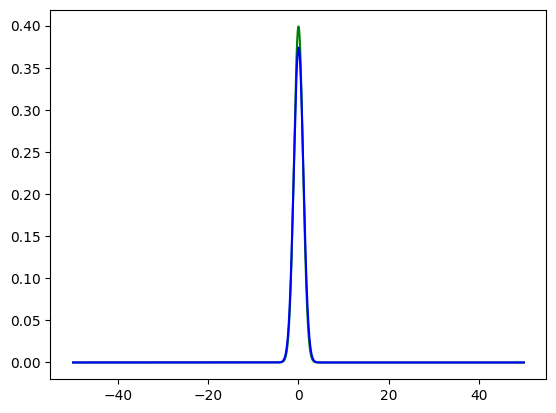

In [195]:
xs = np.arange(-50, 50, 0.01)
plt.plot(xs, scipy.stats.norm.pdf(xs, 0, 1), color="green")
plt.plot(xs, scipy.stats.norm.pdf(xs, bad_med, bad_mad), color="blue")

In [186]:
df["x"][[True, False, False]]

ValueError: Cannot __getitem__ on Series of dtype: 'Float64' with argument: '[True, False, False]' of type: '<class 'list'>'.